# Red Neuronal

## Libraries

In [1095]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.combine import SMOTETomek

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


## Data Exploration

In [1096]:
df = pd.read_pickle('../assignment-TL/data/df_bd.pkl')

In [1097]:
# Muestra las primeras 5 filas del dataframe
print(df.head())

          x1        x2  x3  x4   x5   x6  Target
0  1525020.0   2.32277  10   7  310  718     1.0
1   274197.0  19.31960   6  21   29  541     1.0
2   169780.0  12.50540   6   1   62  763     1.0
3    17227.8  16.52660   2  14   45  728     1.0
4   437237.0  32.53740   4  23   22  683     1.0


In [1098]:
# Calcula el número de filas y columnas del dataframe
print("Shape del dataframe:", df.shape)

Shape del dataframe: (385, 7)


In [1099]:
# Muestra el tipo de dato de cada columna
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
x1        float64
x2        float64
x3          int64
x4          int64
x5          int64
x6          int64
Target    float64
dtype: object


In [1100]:
# Chequeamos si hay valores faltantes
print("Missing values por Columna:")
print(df.isnull().sum())

Missing values por Columna:
x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
Target    0
dtype: int64


In [1101]:
# Muestra las estadísticas básicas de las columnas numéricas
print("Basic statistics of the numerical columns:")
print(df.describe())

Basic statistics of the numerical columns:
                 x1          x2          x3          x4           x5  \
count  3.850000e+02  385.000000  385.000000  385.000000   385.000000   
mean   9.461822e+05   25.798971    5.662338   20.740260    80.337662   
std    1.718188e+06   29.385563    5.395818   31.255501   220.640911   
min    7.021610e+03    0.213802    1.000000    0.000000     4.000000   
25%    1.755010e+05    9.088670    3.000000    4.000000    16.000000   
50%    3.511500e+05   16.644800    5.000000    9.000000    35.000000   
75%    9.127680e+05   29.799900    7.000000   22.000000    70.000000   
max    1.466670e+07  235.558000   63.000000  231.000000  3411.000000   

                x6      Target  
count   385.000000  385.000000  
mean    576.779221    0.787013  
std     192.118238    0.409951  
min      44.000000    0.000000  
25%     467.000000    1.000000  
50%     664.000000    1.000000  
75%     714.000000    1.000000  
max    1147.000000    1.000000  


In [1102]:
# Chequea la distribución de la variable target
print("Distribución de la variable target:")
print(df['Target'].value_counts())

Distribución de la variable target:
Target
1.0    303
0.0     82
Name: count, dtype: int64


## Feature Selection

El código emplea tres métodos para la selección de características. Primero, utiliza un modelo de Random Forest para calcular la importancia de cada variable. Luego, aplica la técnica de importancia de permutación para evaluar el impacto de cada característica al permutar sus valores. Por último, calcula el Factor de Inflación de la Varianza (VIF) para detectar la multicolinealidad entre las características, identificando aquellas con alta correlación. Estos métodos proporcionan una visión integral de la importancia y relación entre las características, contribuyendo así a mejorar la interpretación y el rendimiento del modelo predictivo.


Primero, usamos un modelo de Random Forest, el código utiliza el atributo feature_importances_ para calcular la importancia de cada característica en la predicción del objetivo. Esta importancia se basa en cómo la inclusión de cada característica afecta la precisión de las predicciones durante el entrenamiento del bosque aleatorio. Luego, los nombres de las características y sus importancias se almacenan en un DataFrame para visualizar la importancia de las características por un gráfico de barras. 

https://scikit-learn.org/dev/auto_examples/ensemble/plot_forest_importances.html

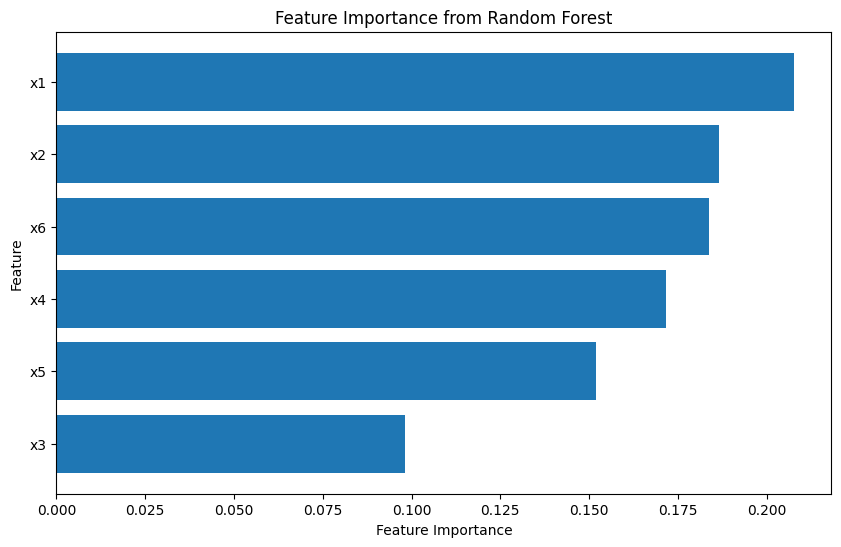

In [1103]:
# Separamos las variables predictoras de la variable target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Dividiendo el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entre un modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtenemos la importancia de las variables
importances = rf.feature_importances_

# Obtenemos los nombres de las variables
feature_names = df.columns[:-1]

# Creamos un dataframe con las variables y su importancia
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Ploteamos la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

Una vez entrenado el modelo de Random Forest, el código calcula la importancia de las características mediante la técnica de importancia de permutación. En este proceso, se evalúa el impacto de cada característica al permutar aleatoriamente sus valores y observar cómo esto afecta la métrica de evaluación del modelo, como la precisión o el ROC-AUC. Se repite este proceso varias veces para obtener una estimación más robusta de la importancia de las características. El resultado se almacena en una estructura de datos que contiene información sobre la importancia de cada característica. Este enfoque proporciona una medida de la importancia relativa de las características al evaluar cómo su perturbación afecta el rendimiento del modelo, lo que contribuye a la selección y la interpretación de características para mejorar el modelo predictivo.

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance

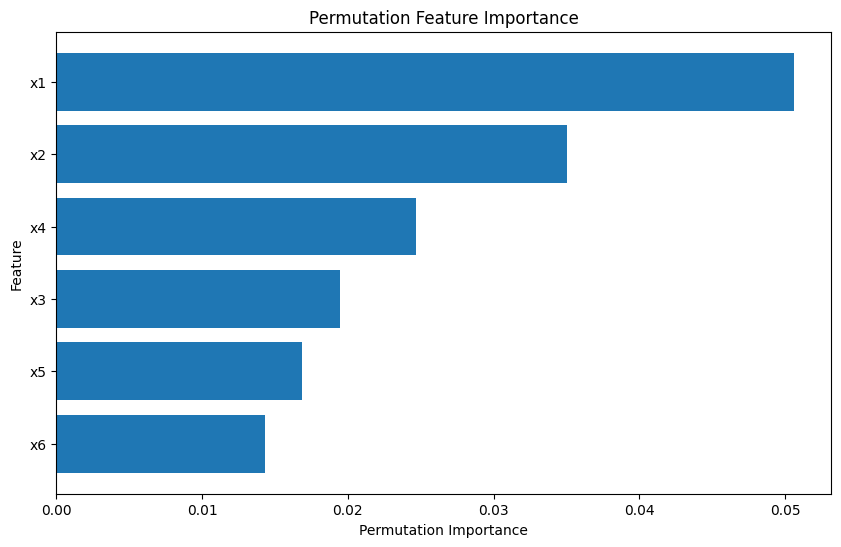

In [1104]:
# Calculamos la importancia de las variables con permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Creamos un dataframe con las variables y su importancia
perm_importances = pd.DataFrame({'feature': feature_names, 'importance': result.importances_mean})
perm_importances = perm_importances.sort_values(by='importance', ascending=False)

# Ploteamos la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(perm_importances['feature'], perm_importances['importance'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

El código define una función llamada calculate_vif que calcula el Factor de Inflación de la Varianza (VIF) para cada característica en un DataFrame, excluyendo la variable objetivo. Utiliza la función variance_inflation_factor de la biblioteca statsmodels para calcular el VIF, que mide la multicolinealidad entre las características al cuantificar cuánto aumenta la varianza de un coeficiente de regresión debido a la correlación con otras características.

https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

In [1105]:
# Creamos una función para calcular el VIF y guardarlo en un DataFrame
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

vif_df = calculate_vif(df.iloc[:, :-1])  # Excluiremos la variable target
print(vif_df)

  feature       VIF
0      x1  1.242173
1      x2  1.860930
2      x3  2.597374
3      x4  1.460679
4      x5  1.410494
5      x6  3.352834


Sin embargo, al recibir resultados distintos con los tres métodos de feature selection decidimos no eliminar ninguna feature. Lo cual permitió los mejores resultados en pruebas preliminares. 

## Data Augmentation

SMOTETomek es una técnica de remuestreo utilizada para abordar el desequilibrio de clases en conjuntos de datos. Combina dos métodos: SMOTE (Synthetic Minority Over-sampling Technique) y Tomek Links. SMOTE genera muestras sintéticas para la clase minoritaria, mientras que Tomek Links elimina las instancias de la clase mayoritaria que están más cerca de las instancias de la clase minoritaria. Este enfoque busca crear un conjunto de datos más balanceado y separable, mejorando así el rendimiento de los modelos de aprendizaje automático en tareas de clasificación con clases desequilibradas.

https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html

In [1106]:
# Aplicamos SMOTETomek para balancear las clases con datos sintéticos
def smote_augmentation(X, y):
    sm = SMOTETomek(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res)

X = df.drop('Target', axis=1)
y = df['Target']

X, y = smote_augmentation(X, y)
print('After SMOTE:', X.shape, y.shape)


After SMOTE: (442, 6) (442,)


## Entrenamiento del Modelo

In [1107]:
# Dividimos el dataset en training y testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos las features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1108]:
# Generamos los pesos de clase para balancear el dataset
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0, 1: 1.0}


In [1109]:
# Creamos un modelo de red neuronal
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compilamos el modelo con Adam optimizando el binary crossentropy
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[BinaryAccuracy()])

In [1110]:
# Definimos el early stopping
early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20


18/18 [==============================] - 1s 10ms/step - loss: 0.7418 - binary_accuracy: 0.5390 - val_loss: 0.7656 - val_binary_accuracy: 0.4789
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.7239 - binary_accuracy: 0.5993 - val_loss: 0.7759 - val_binary_accuracy: 0.5070
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.7150 - binary_accuracy: 0.6206 - val_loss: 0.7826 - val_binary_accuracy: 0.5070
Epoch 4/20
18/18 [==============================] - 0s 3ms/step - loss: 0.7229 - binary_accuracy: 0.5851 - val_loss: 0.7810 - val_binary_accuracy: 0.5211
Epoch 5/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6965 - binary_accuracy: 0.6206 - val_loss: 0.7889 - val_binary_accuracy: 0.5211
Epoch 6/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6936 - binary_accuracy: 0.6099 - val_loss: 0.7896 - val_binary_accuracy: 0.5070
Epoch 7/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6769 - binar

In [1111]:
# Predecimos las probabilidades y sus clases correspondientes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
# Hacemos un reporte de las métricas de evaluación
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.78        45
         1.0       0.76      0.84      0.80        44

    accuracy                           0.79        89
   macro avg       0.79      0.79      0.79        89
weighted avg       0.79      0.79      0.79        89

ROC-AUC Score: 0.8242424242424242


In [1112]:
# Evaluación del Modelo General
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Imprimimos las métricas
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\n")

Accuracy: 0.7865
Precision: 0.7551
Recall: 0.8409
F1 Score: 0.7957




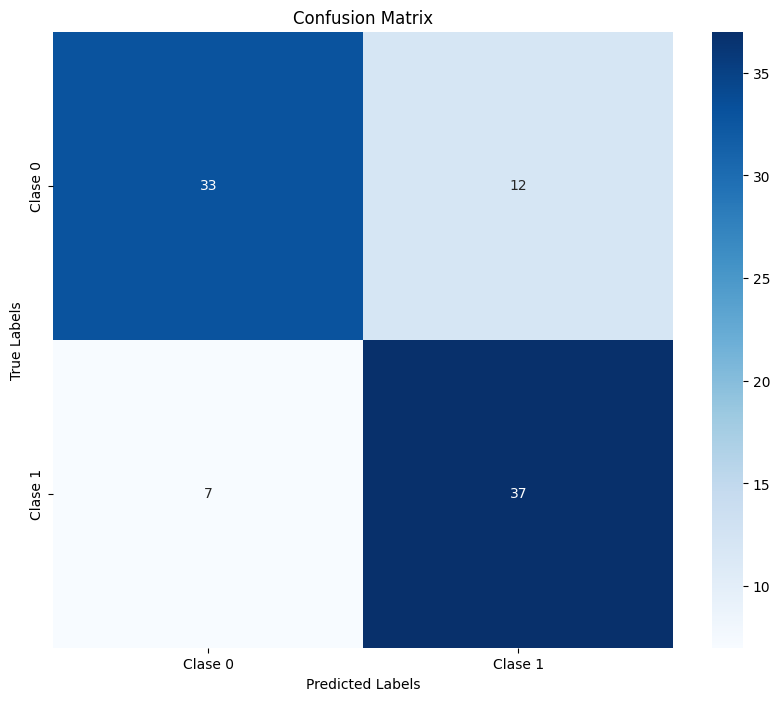

In [1113]:
# Definiendo una función para imprimir la matriz de confusión
def print_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Etiquetas de clase (puedes ajustarlas según tu conjunto de datos)
class_labels = ['Clase 0', 'Clase 1']

# Imprimir la matriz de confusión
print_confusion_matrix(confusion_matrix(y_test, y_pred), labels=class_labels)